In [1]:
from tqdm.notebook import tqdm
import pickle, gzip
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import torch

import nibabel as nib
from nilearn.image import resample_img

from neurovlm.data import data_dir
from neurovlm.models import Specter
from neurovlm.retrieval_resources import (
    _load_autoencoder, _proj_head_image_infonce, _proj_head_text_infonce, _load_masker
)

In [2]:
# Load network atlases
with gzip.open(data_dir / "networks_arrays.pkl.gz", "rb") as f:
    networks = pickle.load(f)

network_imgs = []
for k in networks.keys():
    for a in networks[k].keys():
        network_imgs.append((k, a, nib.Nifti1Image(networks[k][a]["array"], affine=networks[k][a]["affine"])))

networks = [i for i in network_imgs if i[0] not in ["UKBICA", "HCPICA"]]

# Load models
specter = Specter("allenai/specter2_aug2023refresh", adapter="adhoc_query")
proj_head_text = _proj_head_text_infonce()
proj_head_image = _proj_head_image_infonce()
autoencoder = _load_autoencoder()
masker = _load_masker()

There are adapters available but none are activated for the forward pass.


In [23]:
proj_head_text = torch.load(data_dir / "proj_head_text_infonce.pt")
proj_head_image = torch.load(data_dir / "proj_head_image_infonce.pt")

UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL neurovlm.models.TextAligner was not an allowed global by default. Please use `torch.serialization.add_safe_globals([neurovlm.models.TextAligner])` or the `torch.serialization.safe_globals([neurovlm.models.TextAligner])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.

In [24]:
if not (data_dir / "networks_emb.pt").exists():
    # Resample networks
    networks_resampled = []

    for img in tqdm(networks, total=len(networks)):
        img = img[2]
        img_arr = img.get_fdata()

        if len(np.unique(img_arr)) == 2:
            # binary data
            img_resampled = resample_img(img, masker.affine_, interpolation="nearest")
        else:
            img_resampled = resample_img(img, masker.affine_)
            img_resampled_arr = img_resampled.get_fdata()
            img_resampled_arr[img_resampled_arr < 0] = 0.
            thresh = np.percentile(img_resampled_arr.flatten(), 95)
            img_resampled_arr[img_resampled_arr < thresh] = 0.
            img_resampled_arr[img_resampled_arr >= thresh] = 1.
            img_resampled = nib.Nifti1Image(img_resampled_arr, affine=masker.affine_)

        networks_resampled.append(img_resampled)

    # Encode networks
    networks_embed = []
    for v in tqdm(networks_resampled, total=len(networks_resampled)):
        with torch.no_grad():
            networks_embed.append(autoencoder.encoder(torch.from_numpy(masker.transform(v))))
    networks_embed = torch.vstack(networks_embed)
    torch.save(networks_embed, data_dir / "networks_emb.pt")

else:
    networks_embed = torch.load(data_dir / "networks_emb.pt")

In [25]:
label_map = [
 ('VIS-P', 'unknown'), # this is a precuneus mask
 ('CG-OP', 'cingulo_opercular'),
 ('DN-B', 'default_mode'),
 ('SMOT-B', 'somatomotor'),
 ('AUD', 'auditory'),
 ('PM-PPr', 'somatomotor'),
 ('dATN-B', 'attention'),
 ('SMOT-A', 'somatomotor'),
 ('LANG', 'language'),
 ('FPN-B', 'frontoparietal_control'),
 ('FPN-A', 'frontoparietal_control'),
 ('dATN-A', 'attention'),
 ('VIS-C', 'visual'),
 ('SAL/PMN', 'cingulo_opercular'),
 ('DN-A', 'default_mode'),
 ('NONE', 'unknown'),
 ('Visual1', 'visual'),
 ('Visual2', 'visual'),
 ('Somatomotor', 'somatomotor'),
 ('CingOperc', 'cingulo_opercular'),
 ('DorsAttn', 'attention'),
 ('Language', 'language'),
 ('FrontPar', 'frontoparietal_control'),
 ('Auditory', 'auditory'),
 ('Default', 'default_mode'),
 ('PostMulti', 'unknown'),
 ('VentMulti', 'unknown'),
 ('OrbitAffective', 'unknown'),
 ('Emo/Interoception1', 'unknown'),
 ('Emo/Interoception2', 'unknown'),
 ('Emo/Interoception3', 'unknown'),
 ('Emo/Interoception4', 'unknown'),
 ('Mot/Visspatial1', 'somatomotor'),
 ('Mot/Visspatial2', 'somatomotor'),
 ('Mot/Visspatial3', 'somatomotor'),
 ('Mot/Visspatial4', 'somatomotor'),
 ('Visual1', 'visual'),
 ('Visual2', 'visual'),
 ('Visual3', 'visual'),
 ('DivergentCog1', 'unknown'),
 ('DivergentCog3', 'unknown'),
 ('DivergentCog4', 'unknown'),
 ('DivergentCog5', 'unknown'),
 ('DivergentCog6', 'unknown'),
 ('medial frontal', 'frontoparietal_control'),
 ('frontoparietal', 'frontoparietal_control'),
 ('default mode', 'default_mode'),
 ('motor cortex', 'somatomotor'),
 ('visual A', 'visual'),
 ('visual B', 'visual'),
 ('visual association', 'visual'),
 ('subcortical cerebellum', 'unknown'),
 ('AntSal', 'cingulo_opercular'),
 ('Auditory', 'auditory'),
 ('DorsalDMN', 'default_mode'),
 ('HighVisual', 'visual'),
 ('Language', 'language'),
 ('LECN', 'frontoparietal_control'),
 ('PostSal', 'cingulo_opercular'),
 ('Precuneus', 'default_mode'),
 ('PrimVisual', 'visual'),
 ('RECN', 'frontoparietal_control'),
 ('Sensorimotor', 'somatomotor'),
 ('VentralDMN', 'default_mode'),
 ('Visuospatial', 'attention'),
 ('Default', 'default_mode'),
 ('LatVis', 'visual'),
 ('FrontPar', 'frontoparietal_control'),
 ('MedVis', 'visual'),
 ('DorsAttn', 'attention'),
 ('Premotor', 'somatomotor'),
 ('Language', 'language'),
 ('Salience', 'cingulo_opercular'),
 ('CingOperc', 'cingulo_opercular'),
 ('HandSM', 'somatomotor'),
 ('FaceSM', 'somatomotor'),
 ('Auditory', 'auditory'),

 ('AntMTL', 'unknown'),
 ('PostMTL', 'unknown'),
 ('ParMemory', 'unknown'),
 ('Context', 'unknown'),
 ('FootSM', 'somatomotor'),
 ('Visual', 'visual'),
 ('VentAttn', 'attention'),
 ('DorsalSM', 'somatomotor'),
 ('VentralSM', 'somatomotor'),
 ('MedPar', 'default_mode'),
 ('ParOcc', 'visual'),
 ('SCAN', 'frontoparietal_control'),
 ('Cingulo-Opercular', 'cingulo_opercular'),
 ('Effector-hand', 'somatomotor'),
 ('Effector-mouth', 'somatomotor'),
 ('Effector-foot', 'somatomotor'),
 ('SM', 'somatomotor'),
 ('LateralSM', 'somatomotor'),
 ('ResponseOneHanded(1RESP)', 'somatomotor'),
 ('ResponseTwoHanded(2RESP)', 'somatomotor'),
 ('AuditoryAttentionResponse(AAR)', 'auditory'),
 ('AuditoryPrimarySensory(AUD)', 'auditory'),
 ('DMNNovel(DMNA)', 'default_mode'),
 ('DMNTraditional(DMNB)', 'default_mode'),
 ('FocusOnVisualFeatures(FoVF)', 'visual'),
 ('Initiation(INIT)', 'unknown'),
 ('Language(LN)', 'language'),
 ('MAIN', 'unknown'),
 ('MultipleDemand(MDN)', 'frontoparietal_control'),
 ('Re-evaluation(RE-EV)', 'frontoparietal_control'),
 ('DefaultA', 'default_mode'),
 ('DefaultB', 'default_mode'),
 ('DefaultC', 'default_mode'),
 ('Language', 'language'),
 ('ContA', 'frontoparietal_control'),
 ('ContB', 'frontoparietal_control'),
 ('ContC', 'frontoparietal_control'),
 ('SalVenAttnA', 'cingulo_opercular'),
 ('SalVenAttnB', 'cingulo_opercular'),
 ('DorsAttnA', 'attention'),
 ('DorsAttnB', 'attention'),
 ('Aud', 'auditory'),
 ('SomMotA', 'somatomotor'),
 ('SomMotB', 'somatomotor'),
 ('VisualA', 'visual'),
 ('VisualB', 'visual'),
 ('VisualC', 'visual'),
 ('TempPar', 'frontoparietal_control'),
 ('LimbicA', 'unknown'), # these are dlmpc and temporal lobe
 ('LimbicB', 'unknown'),
 ('SalVentAttnB', 'cingulo_opercular'),
 ('SalVentAttnA', 'cingulo_opercular'),
 ('VisPeri', 'visual'),
 ('VisCent', 'visual'),
 ('SomatomotorA', 'somatomotor'),
 ('SomatomotorB', 'somatomotor'),
 ('Sal/VenAttnA', 'cingulo_opercular'),
 ('Sal/VenAttnB', 'cingulo_opercular'),
 ('ControlC', 'frontoparietal_control'),
 ('ControlA', 'frontoparietal_control'),
 ('ControlB', 'frontoparietal_control'),
 ('Visual', 'visual'),
 ('Somatomotor', 'somatomotor'),
 ('DorsAttn', 'attention'),
 ('Sal/VenAttn', 'cingulo_opercular'),
 ('Limbic', 'unknown'),
 ('Control', 'frontoparietal_control'),
 ('Default', 'default_mode')]

In [26]:
# 1) Define a set of target labels (mutually exclusive)
target_labels = [
    "visual",
    "somatomotor",
    "auditory",
    "language",
    "attention",
    "frontoparietal_control",
    "cingulo_opercular",
    "default_mode",
    "limbic_affective",
    "memory_mtl",
    "unknown",
]

# 2) labels: same length/order as your provided 145-element true_labels array
labels = [i[1] for i in label_map]
assert len(labels) == 145

In [27]:
# 3) text_labels: {target_label: description}
text_labels = {
    "visual": (
        "Visual network [SEP] "
        "Supports visual perception and visual attention. "
        "Anchored in primary visual cortex and higher-order visual association cortex in occipital and occipito-temporal regions."
    ),
    "somatomotor": (
        "Somatomotor network [SEP] "
        "Supports movement execution and somatic sensation with body-map organization (hand/face/foot). "
        "Centered on primary motor and primary somatosensory cortex with premotor and supplementary motor contributions."
    ),
    "auditory": (
        "Auditory network [SEP] "
        "Supports hearing and early sound feature processing (e.g., pitch and timbre), not language meaning. "
        "Anchored in Heschl’s gyrus and surrounding superior temporal cortex."
    ),
    "language": (
        "Language network [SEP] "
        "Supports language comprehension and production (semantics and syntax), distinct from basic auditory processing. "
        "Typically left-lateralized, involving inferior frontal gyrus and posterior temporal cortex with temporoparietal support."
    ),
    "attention": (
        "Attention network [SEP] "
        "Supports sustained, top-down attentional selection and goal-directed visuospatial orienting. "
        "Anchored in intraparietal/superior parietal regions and frontal eye fields."
    ),
    "frontoparietal_control": (
        "Frontoparietal control network [SEP] "
        "The executive control network. Supports flexible cognitive control and rapid adaptation (rule maintenance, goal switching, multiple-demand control). "
        "Anchored in lateral prefrontal cortex and inferior parietal cortex."
    ),
    "cingulo_opercular": (
        "Cingulo-opercular (salience) network [SEP] "
        "Supports performance monitoring and stable task-set control, and flags behaviorally relevant signals that should influence control. "
        "Anchored in dorsal anterior cingulate/medial frontal cortex and anterior operculum/anterior insula."
    ),
    "default_mode": (
        "Default mode network [SEP] "
        "Supports internally oriented cognition such as autobiographical memory, self-referential processing, and conceptual integration. "
        "Anchored in medial prefrontal cortex, posterior cingulate/precuneus, and angular gyrus."
    ),
    # "limbic_affective": (
    #     "Limbic-affective network [SEP] "
    #     "Supports affect, valuation, and emotion/interoception-linked processing rather than attention or executive control. "
    #     "Subcortical structures. Orbitofrontal and ventromedial prefrontal cortex with limbic-associated temporal and insular regions."
    # ),
    # "memory_mtl": (
    #     "Medial temporal lobe [SEP] "
    #     "Supports episodic memory via associative binding and context-dependent retrieval. "
    #     "Anchored in hippocampus and parahippocampal/entorhinal cortex and linked to posterior midline/parietal memory regions."
    # ),
}


In [28]:
import torch.nn.functional as F
with torch.no_grad():
    text_embed = proj_head_text(specter(list(text_labels.values())))
    # text_embed = proj_head_text(specter(
    #     [i.split(" [SEP]")[0] for i in list(text_labels.values())]
    # ))

text_embed = F.normalize(text_embed, dim=1)
networks_embed = F.normalize(proj_head_image(networks_embed), dim=1)

sim = (networks_embed @ text_embed.T)
pred = torch.argmax(sim, dim=1)
lookup = {v: k for k, v in zip(range(len(text_labels)), list(text_labels.keys()))}
label_inds = np.array([lookup[i] if i != "unknown" else -1 for i in labels ])
mask = label_inds != -1

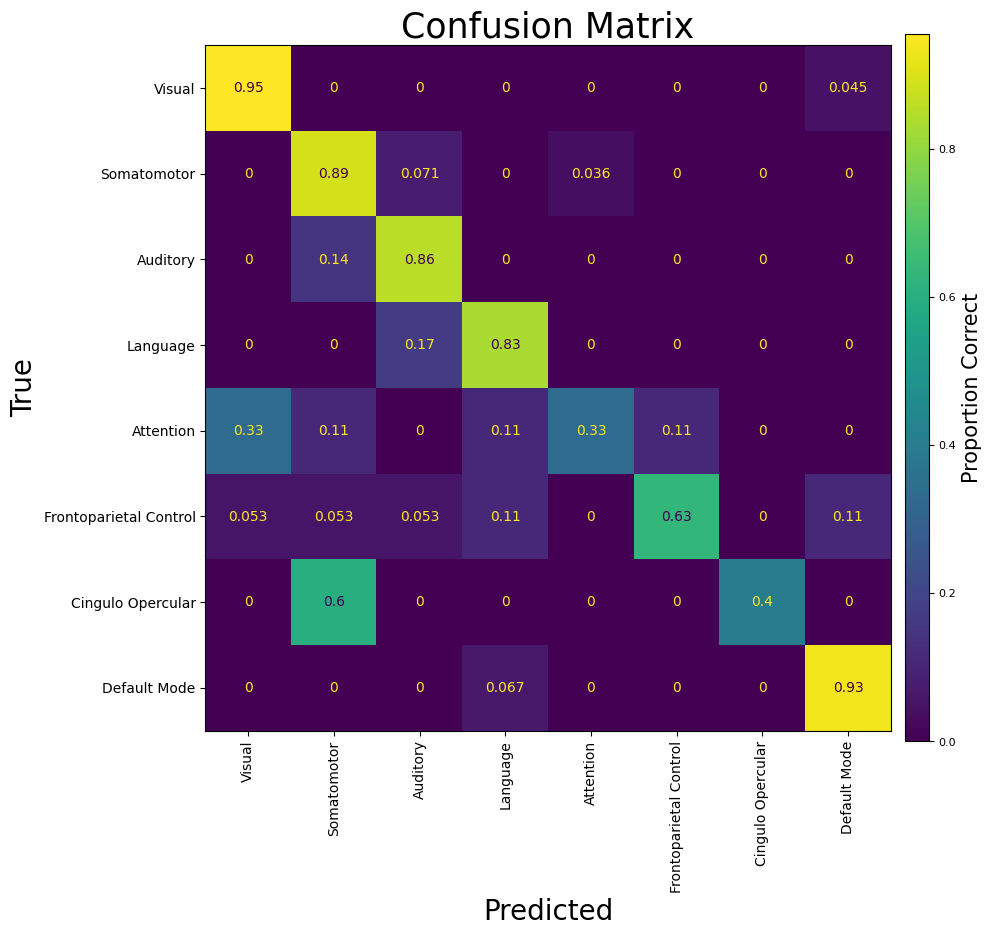

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# ---- inputs (as you have them) ----
y_pred = pred[mask].detach().cpu().numpy().astype(int)     # torch -> numpy ints
y_true = np.asarray(label_inds[mask]).astype(int)          # numpy ints

# ---- mapping: assumes class ids are 0..C-1 in the SAME order as text_labels.keys() ----
class_names = list(text_labels.keys())                     # e.g. 12 names
C = len(class_names)

# ---- sanity checks ----
if y_true.min() < 0 or y_true.max() >= C:
    raise ValueError(f"y_true has values outside [0, {C-1}]: min={y_true.min()}, max={y_true.max()}")
if y_pred.min() < 0 or y_pred.max() >= C:
    raise ValueError(f"y_pred has values outside [0, {C-1}]: min={y_pred.min()}, max={y_pred.max()}")

_labels = np.arange(C, dtype=int)

# ---- plot ----
fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay.from_predictions(
    y_true=y_true,
    y_pred=y_pred,
    labels=_labels,
    display_labels=[" ".join([j.capitalize() for j in i.split("_")]) for i in class_names],
    normalize="true",
    xticks_rotation=90,
    ax=ax,
    colorbar=False
)

im = disp.im_
cbar = ax.figure.colorbar(
    im,
    ax=ax,
    fraction=0.035,   # width of colorbar relative to axes
    pad=0.02,         # gap
    shrink=0.91,      # shorter
    aspect=30,        # thinner/longer ratio
)
cbar.ax.tick_params(labelsize=8)  # optional
cbar.ax.set_ylabel("Proportion Correct", size=15)
ax.set_title("Confusion Matrix", size=25)
ax.set_ylabel("True", size=20,)
ax.set_xlabel("Predicted", size=20)
plt.tight_layout()
plt.savefig(data_dir / "networks_confusion.png", dpi=300)

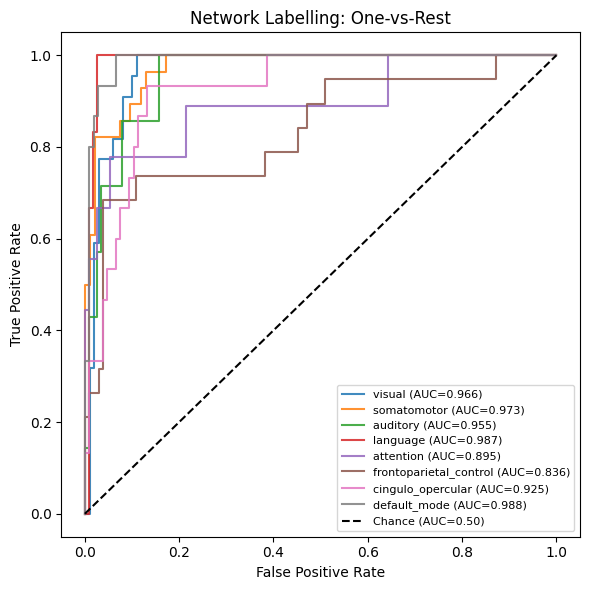

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

y_score = (networks_embed @ text_embed.T)    # (N, C) cosine similarities
y_pred  = y_score.argmax(axis=1)            # (N,) hard prediction (int class id)

y_true = np.asarray(y_true, dtype=int)
y_score = np.asarray(y_score.detach(), dtype=float)

y_pred = y_pred[mask]
y_score = y_score[mask]



C = y_score.shape[1]
Y = label_binarize(y_true, classes=np.arange(C))  # (N, C)
# Y[:, k].shape, y_score[:, k].shape ((131,), (145,))
plt.figure(figsize=(6, 6))

for k in range(C):
    # ROC undefined if class k never appears in y_true
    if Y[:, k].sum() == 0:
        continue
    fpr, tpr, _ = roc_curve(Y[:, k], y_score[:, k])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, alpha=0.85, label=f"{class_names[k]} (AUC={roc_auc:.3f})")

plt.plot([0, 1], [0, 1], "--", color="k", label="Chance (AUC=0.50)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Network Labelling: One-vs-Rest")
plt.legend(fontsize=8)
plt.tight_layout()
plt.savefig(data_dir / "networks_one_v_rest.png", dpi=300)
plt.show()

In [32]:
# Network list
network_labels = list([i for i in text_labels.values()])

# Specter
label_embeddings = F.normalize(specter(network_labels), dim=1)
label_embeddings = F.normalize(proj_head_text(label_embeddings), dim=1)

sim = networks_embed @ label_embeddings.T

inds = sim.argsort(dim=1, descending=True)[:, :2]
primary_labels = [list(text_labels.keys())[i[0]] for i in inds]
secondary_labels = [list(text_labels.keys())[i[1]] for i in inds]

# Results
df = pd.DataFrame({
    "atlas": [i[0] for i in networks],
    "atlas_label": [i[1] for i in networks],
    "true_label": [i[1] for i in label_map],
    "predicted_label_primary": primary_labels,
    "predicted_label_secondary": secondary_labels,
})

df.iloc[:20]

,atlas,atlas_label,true_label,predicted_label_primary,predicted_label_secondary
0,Du,VIS-P,unknown,visual,somatomotor
1,Du,CG-OP,cingulo_opercular,somatomotor,cingulo_opercular
2,Du,DN-B,default_mode,default_mode,language
3,Du,SMOT-B,somatomotor,somatomotor,auditory
4,Du,AUD,auditory,auditory,language
5,Du,PM-PPr,somatomotor,somatomotor,attention
6,Du,dATN-B,attention,visual,attention
7,Du,SMOT-A,somatomotor,somatomotor,frontoparietal_control
8,Du,LANG,language,language,auditory
9,Du,FPN-B,frontoparietal_control,frontoparietal_control,default_mode


/home/rph/neurovlm/.env/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:867: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
<positron-console-cell-120>:2: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.



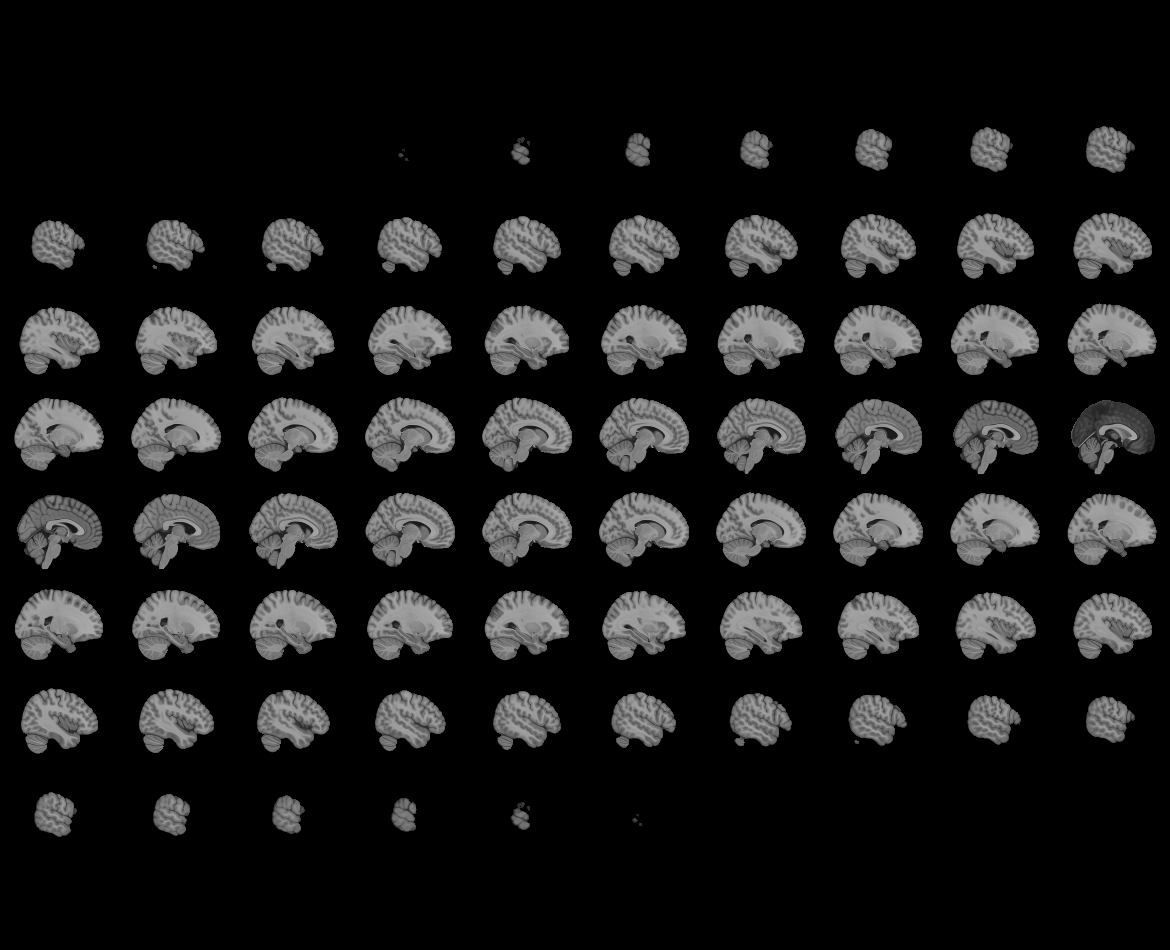
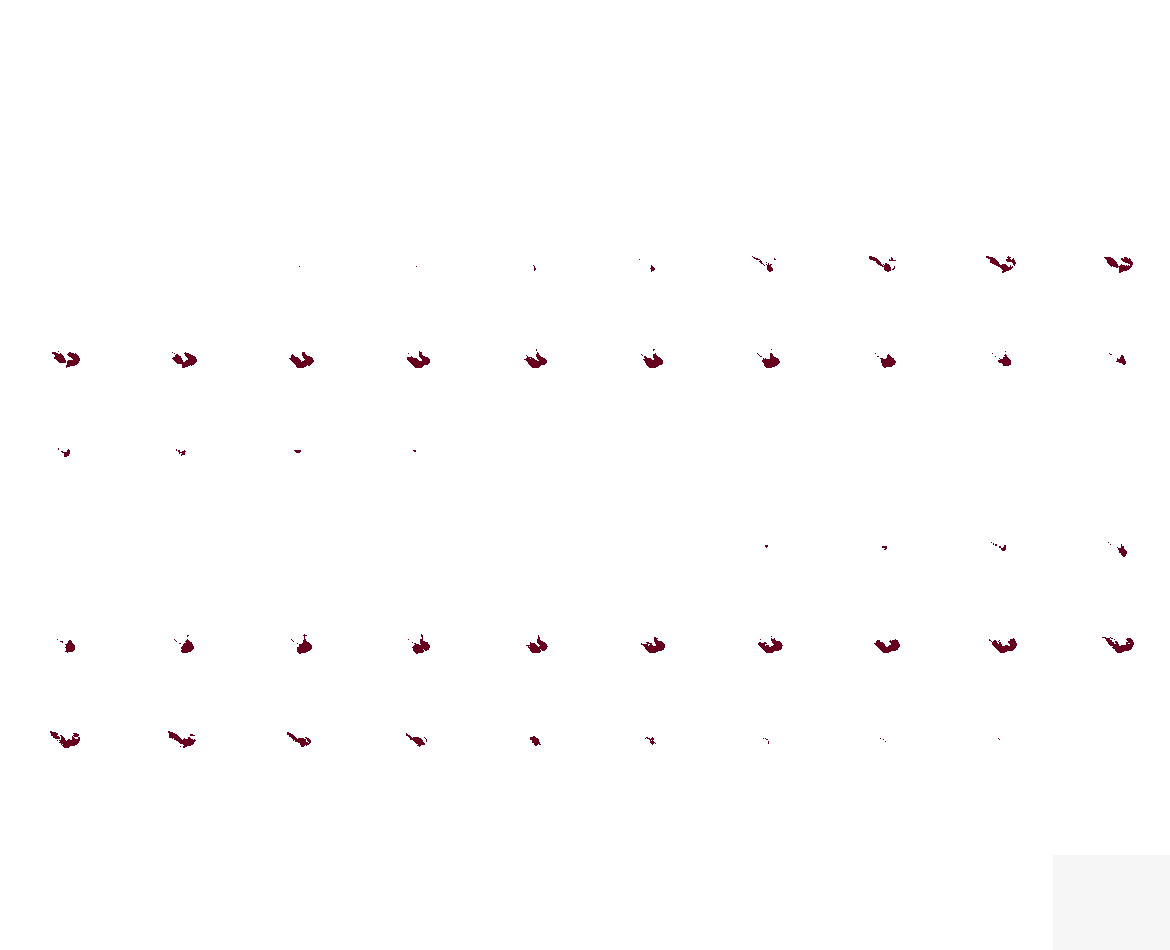

In [ ]:
from nilearn.plotting import view_img
# view_img(networks[77][2])